In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Custom date parser for signup_date in format 'yy-mm-dd' (e.g., '26-04-25')
date_parser = lambda x: pd.to_datetime(x, format='%y-%m-%d')

In [3]:
# Load datasets with appropriate date parsing
customers = pd.read_csv('customer_info.csv', parse_dates=['signup_date'], date_format='%y-%m-%d')
products = pd.read_csv('product_info.csv')
sales = pd.read_csv('sales_data.csv', parse_dates=['order_date'])

In [4]:
# Display the first few rows of each dataset
print("Customers:")
print(customers.head())
print()

print("\nProducts:")
print(products.head())
print()

print("\nSales:")
print(sales.head())

Customers:
  customer_id                    email signup_date  gender   region  \
0      C00001   shaneramirez@gmail.com  2026-04-25    Male  Central   
1      C00002    jpeterson@bernard.com  2011-08-24  Female  Central   
2      C00003  howardmaurice@yahoo.com  2015-05-25    male  Central   
3      C00004      yherrera@arnold.org  2014-06-25  FEMALE  Central   
4      C00005  janetwilliams@gmail.com  2002-05-25    Male     West   

  loyalty_tier  
0       Silver  
1        gold   
2        gold   
3         GOLD  
4       bronze  


Products:
  product_id             product_name       category launch_date  base_price  \
0      P0001       Storage Product 39        Storage    11-03-25       15.88   
1      P0002      Cleaning Product 82       Cleaning    18-08-24       34.23   
2      P0003      Cleaning Product 85       Cleaning    15-07-24        7.92   
3      P0004       Kitchen Product 82        Kitchen    19-04-25        9.13   
4      P0005  Personal Care Product 1  Personal 

In [5]:
# 1. Merge datasets
merged = sales.merge(customers, on='customer_id', how='left') \
              .merge(products, on='product_id', how='left')

In [6]:
print(products.columns)

Index(['product_id', 'product_name', 'category', 'launch_date', 'base_price',
       'supplier_code'],
      dtype='object')


In [7]:
# 2. Clean data

# Drop rows with missing customer or product IDs
sales = sales.dropna(subset=['customer_id', 'product_id'])

# Ensure IDs are treated as string types
sales['customer_id'] = sales['customer_id'].astype(str)
sales['product_id'] = sales['product_id'].astype(str)
customers['customer_id'] = customers['customer_id'].astype(str)
products['product_id'] = products['product_id'].astype(str)

# Clean product prices — keep only positive base prices
products = products[products['base_price'] > 0]

# Clean customer data — remove obviously invalid or missing emails
customers = customers[customers['email'].str.contains('@', na=False)]

# Optional: Strip whitespace from string columns (if applicable)
if 'product_name' in products.columns:
    products['product_name'] = products['product_name'].str.strip()

if 'full_name' in customers.columns:
    customers['full_name'] = customers['full_name'].str.strip()

# Drop duplicate records
sales = sales.drop_duplicates()
products = products.drop_duplicates()
customers = customers.drop_duplicates()

In [8]:
# 3. Merge Datasets

# Merge sales with products on product_id
sales_products = pd.merge(sales, products, on='product_id', how='inner')

# Merge the result with customers on customer_id
full_data = pd.merge(sales_products, customers, on='customer_id', how='inner')

In [9]:
# 4. Feature Engineering

# Convert order_date to datetime if not already
full_data['order_date'] = pd.to_datetime(full_data['order_date'])

# Add useful time features
full_data['year'] = full_data['order_date'].dt.year
full_data['month'] = full_data['order_date'].dt.month
full_data['day_of_week'] = full_data['order_date'].dt.day_name()

In [10]:
# 5. Sample Questions You Can Analyze

# Product Analysis
# What are the top 10 selling products?
top_products = full_data['product_name'].value_counts().head(10)
print(top_products)

product_name
Cleaning Product 70         121
Kitchen Product 53          117
Outdoors Product 55         114
Outdoors Product 91         108
Cleaning Product 84         107
Storage Product 10          105
Cleaning Product 16         103
Cleaning Product 94         102
Personal Care Product 11    101
Cleaning Product 86         101
Name: count, dtype: int64


In [11]:
# What’s the average base price by category?
avg_price_by_category = full_data.groupby('category')['base_price'].mean()
print(avg_price_by_category)

category
Cleaning         22.669655
Kitchen          17.053451
Outdoors         23.251630
Personal Care    26.888179
Storage          25.071062
Name: base_price, dtype: float64


In [12]:
# Sales Trends

# How did sales vary over months?
monthly_sales = full_data.groupby(['year', 'month']).size()
print(monthly_sales)

year    month
2025.0  6.0      2935
dtype: int64


In [13]:
# Which days of the week are most active?
weekday_sales = full_data['day_of_week'].value_counts()
print(weekday_sales)

day_of_week
Saturday    2935
Name: count, dtype: int64


In [14]:
# Customer Behavior

# How many unique customers per month?
unique_customers = full_data.groupby(['year', 'month'])['customer_id'].nunique()
print(unique_customers)

year    month
2025.0  6.0      490
Name: customer_id, dtype: int64


In [15]:
# Which customers spent the most?
top_customers = full_data.groupby('customer_id')['base_price'].sum().sort_values(ascending=False).head(10)
print(top_customers)

customer_id
C00062    395.00
C00440    325.32
C00421    315.13
C00385    314.54
C00491    309.06
C00343    307.38
C00500    302.01
C00192    292.44
C00113    289.67
C00294    286.24
Name: base_price, dtype: float64


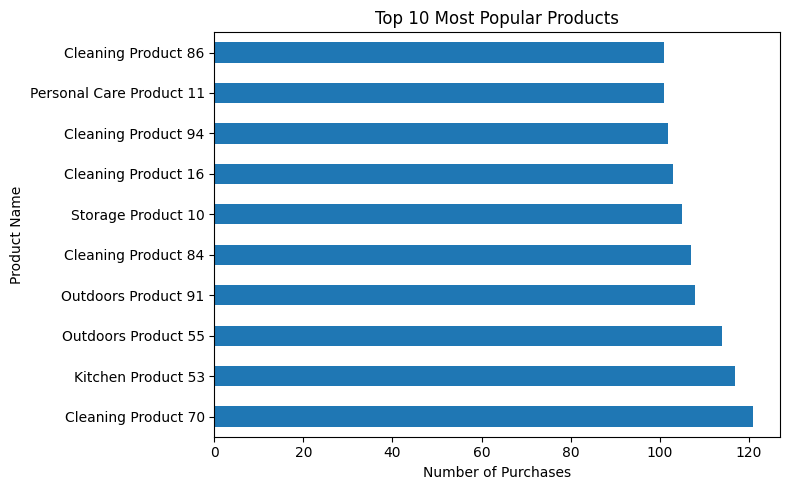

In [16]:
# Plot: Top 10 Most Popular Products
top_products.plot(kind='barh', figsize=(8,5), title='Top 10 Most Popular Products')
plt.xlabel('Number of Purchases')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

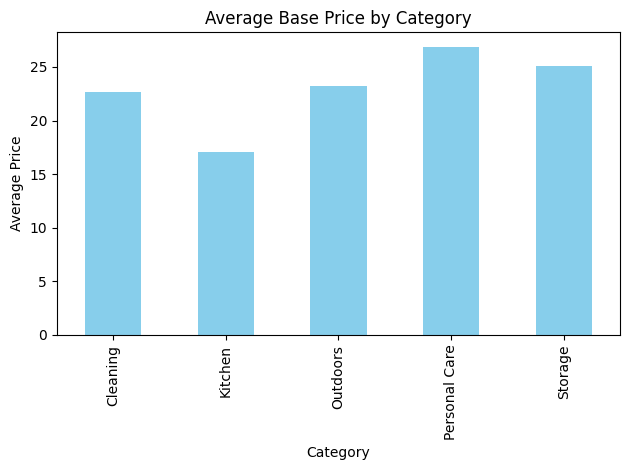

In [17]:
# Plot: Average Base Price by Category
avg_price_by_category.plot(kind='bar', color='skyblue', title='Average Base Price by Category')
plt.ylabel('Average Price')
plt.xlabel('Category')
plt.tight_layout()
plt.show()

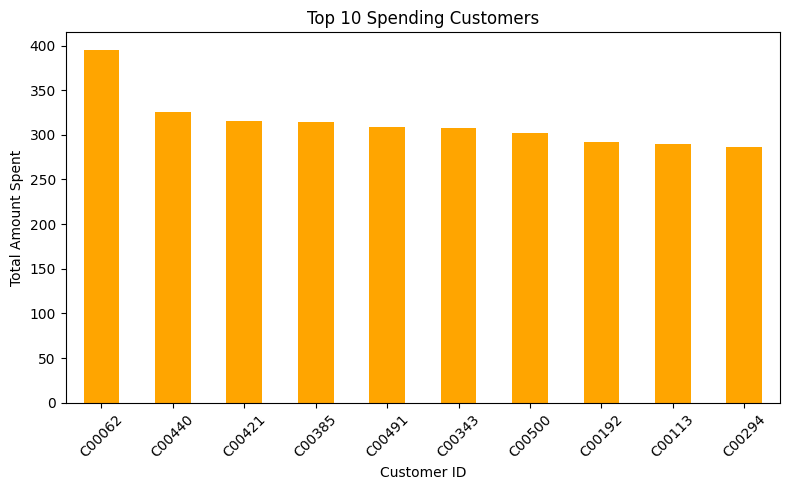

In [18]:
# Plot: Top Spending Customers
top_customers.plot(kind='bar', color='orange', figsize=(8,5), title='Top 10 Spending Customers')
plt.ylabel('Total Amount Spent')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()